In [2]:
import json
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
from numpy import *
import math
import matplotlib.pyplot as plt
from ipywidgets import *
from IPython.display import display
plt.style.use('ggplot')
from pymongo import MongoClient

import pandas as pd
from pandas.io.json import json_normalize
import plotly.plotly as py
import plotly.graph_objs as go

from datetime import datetime
import pandas_datareader.data as web
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from pandas import read_csv

In [3]:
from influxdb import DataFrameClient

In [4]:
#client = DataFrameClient('34.217.33.66', 32589, 'root', 'root', 'k8s')
mongoclient = MongoClient('localhost', 27017)


In [10]:
def getMongoDf(dbName):
    db = mongoclient[dbName]
    datapoints = list(db.loadtestmodels.find({}))
    dfMongo = json_normalize(datapoints)
    dfMongo = dfMongo.drop(['__v'], axis=1)
    dfMongo = dfMongo.drop(['_id'], axis=1)
    dfMongo = dfMongo.drop(['instanceIndexS'], axis=1)
    if('latencyS.errorCodes.-1' in dfMongo.columns):
        dfMongo = dfMongo.drop(['latencyS.errorCodes.-1'], axis=1)
    dfMongo = dfMongo.drop(['latencyS.percentiles.50'], axis=1)
    dfMongo = dfMongo.drop(['latencyS.percentiles.90'], axis=1)
    
    dfMongo = dfMongo.drop(['resultS.headers.x-content-type-options'], axis=1)
    dfMongo = dfMongo.drop(['latencyS.percentiles.95'], axis=1)
    dfMongo = dfMongo.drop(['latencyS.percentiles.99'], axis=1)
    dfMongo = dfMongo.drop(['resultS.headers.access-control-allow-headers'], axis=1)
    dfMongo = dfMongo.drop(['resultS.body'], axis=1)
    dfMongo = dfMongo.drop(['resultS.headers.access-control-allow-methods'], axis=1)
    dfMongo = dfMongo.drop(['resultS.headers.access-control-allow-origin'], axis=1)
    
    dfMongo = dfMongo.drop(['resultS.headers.date'], axis=1)
    dfMongo = dfMongo.drop(['resultS.headers.content-type'], axis=1)
    dfMongo = dfMongo.drop(['resultS.headers.x-powered-by'], axis=1)  
    
    dfMongo = dfMongo.drop(['resultS.host'], axis=1)
    dfMongo = dfMongo.drop(['resultS.headers.etag'], axis=1)
    #dfMongo = dfMongo.drop(['resultS.host'], axis=1)
    
    dfMongo = dfMongo.drop(['resultS.instanceIndex'], axis=1)
    dfMongo = dfMongo.drop(['resultS.method'], axis=1)
    dfMongo = dfMongo.drop(['resultS.headers.content-length'], axis=1)
    
    dfMongo = dfMongo.drop(['resultS.path'], axis=1)
    dfMongo = dfMongo.drop(['resultS.headers.connection'], axis=1)
    
    dfMongo = dfMongo.drop(['requestIndexS'], axis=1)
    dfMongo = dfMongo.drop(['latencyS.totalErrors'], axis=1)
    dfMongo = dfMongo.drop(['resultS.statusCode'], axis=1)
    dfMongo['time'] = pd.to_datetime(dfMongo['time'], unit='ms')
    dfMongo = dfMongo.set_index('time')
  
    return dfMongo

In [11]:
def getMongoDfKube(dbName):
    db = mongoclient[dbName]
    datapoints = list(db.kubernetesData.find({}))
    dfMongo = json_normalize(datapoints)
    dfMongo = dfMongo.drop(['_id'], axis=1)
    dfMongo = dfMongo.drop(['data.containersInfo'], axis=1)
    
    dfMongo = dfMongo.drop(['data.eventsInfo'], axis=1)
    dfMongo = dfMongo.drop(['data.podInfo'], axis=1)
    dfMongo = dfMongo.drop(['data.servicesInfo'], axis=1)
    #dfMongo = dfMongo.drop(['data.hpaInfo'], axis=1)
    dfMongo = dfMongo.drop(['data.nodeInfo'], axis=1)
    #dfMongo = json_normalize(dfMongo)
    #dfMongo = dfMongo.drop(['data.rpcInfo'], axis=1)
    df = dfMongo
    df['time'] = pd.to_datetime(df['time'],unit='ms')
    dfhpa = pd.DataFrame(df['data.hpaInfo'])
    df2 = pd.DataFrame(df['data.rpcInfo'])
    df2[['rpc1','rpc2']] = pd.DataFrame(df2['data.rpcInfo'].values.tolist(), index= df2.index)
    dfhpa = pd.DataFrame(dfhpa['data.hpaInfo'].values.tolist(), columns=['hpa1'])    
    df3 = pd.DataFrame(df2['data.rpcInfo'].values.tolist(), columns=['rpc1','rpc2'])
    
    list1= df3['rpc1'].values.tolist()
    
    list2 = dfhpa['hpa1'].values.tolist()
    
    
    rpcInfoDf = json_normalize(list1)
    
    hpainfordf = json_normalize(list2)
    rpcInfoDf['time'] = pd.to_datetime(df['time'], unit='ms')
    rpcInfoDf = rpcInfoDf.drop(['name'], axis=1)
    rpcInfoDf = rpcInfoDf.drop(['namespace'], axis=1)
    rpcInfoDf = rpcInfoDf.drop(['creationTimestamp'], axis=1)
    
    hpainfordf = hpainfordf.drop(['name'], axis=1)
    hpainfordf = hpainfordf.drop(['namespace'], axis=1)
    hpainfordf = hpainfordf.drop(['status'], axis=1)
    
    dfhpastats = pd.DataFrame(hpainfordf['statsCurrent'].values.tolist(), columns=['statsCurrent']) 
    list4 = dfhpastats['statsCurrent'].values.tolist()
    
    temp = json_normalize(list4)
    
    hpainfordf['currentAverageUtilization'] = temp['currentAverageUtilization']
    hpainfordf['currentAverageValue'] = temp['currentAverageValue']
    hpainfordf['Resourcename'] = temp['Resourcename']
    hpainfordf = hpainfordf.drop(['statsCurrent'], axis=1)
    hpainfordf = hpainfordf.drop(['lastScaleTime'], axis=1)
    hpainfordf = hpainfordf.drop(['creationTimestamp'], axis=1)
    hpainfordf = hpainfordf.drop(['currentReplicas'], axis=1)
    hpainfordf = hpainfordf.drop(['currentAverageUtilization'], axis=1)
    hpainfordf = hpainfordf.drop(['currentAverageValue'], axis=1)
    result = pd.concat([rpcInfoDf, hpainfordf], axis=1)
    #result = result.set_index('time')
    return result


In [12]:
def assignValuesRequest(dbName):
    df = getMongoDf(dbName)
    return df
    
def assignValuesKubeData(dbName):
    df = getMongoDfKube(dbName)
    return df    

In [13]:
dbName = 'aws_kube_random'
requestDF = assignValuesRequest(dbName)
requestDF = requestDF.fillna(0)
kubeDF= assignValuesKubeData(dbName)
requestDF.reset_index(drop=True, inplace=True)
kubeDF.reset_index(drop=True, inplace=True)
finalDF = pd.concat([requestDF, kubeDF], axis=1)
finalDF = finalDF.set_index('time')
finalDF.to_csv('requestKube_aws_random.csv')

In [14]:
dbName = 'aws_kube_linearIncrease'
requestDF = assignValuesRequest(dbName)
requestDF = requestDF.fillna(0)
kubeDF= assignValuesKubeData(dbName)
requestDF.reset_index(drop=True, inplace=True)
kubeDF.reset_index(drop=True, inplace=True)
finalDF = pd.concat([requestDF, kubeDF], axis=1)
finalDF = finalDF.set_index('time')
finalDF.to_csv('requestKube_aws_linearIncrease.csv')

In [15]:
finalDF.head()

,errorS,latencyS.maxLatencyMs,latencyS.meanLatencyMs,latencyS.minLatencyMs,latencyS.rps,latencyS.totalRequests,latencyS.totalTimeSeconds,requestElapsedS,resultS.requestElapsed,resultS.requestIndex,...,fullyLabeledReplicas,observedGeneration,readyReplicas,replicas,currentCPUUtilizationPercentage,desiredReplicas,maxReplicas,minReplicas,targetCPUUtilizationPercentage,Resourcename
time,,,,,,,,,,,,,,,,,,,,,
2017-12-22 23:38:13.717,0,24,24.5,24,19,1,0.052920,24.545375,24.545375,0,...,1.0,26.0,1.0,1.0,0.0,1.0,10.0,1.0,20.0,cpu
2017-12-22 23:38:15.724,0,154,73.7,24,16,4,0.246616,154.562096,154.562096,3,...,1.0,26.0,1.0,1.0,0.0,1.0,10.0,1.0,20.0,cpu
2017-12-22 23:38:21.730,0,164,91.9,24,19,5,0.258993,164.701363,164.701363,4,...,1.0,26.0,1.0,1.0,0.0,1.0,10.0,1.0,20.0,cpu
2017-12-22 23:38:19.728,0,253,118.7,24,17,6,0.352374,253.073526,253.073526,5,...,1.0,26.0,1.0,1.0,0.0,1.0,10.0,1.0,20.0,cpu
2017-12-22 23:38:23.732,0,253,135.3,24,19,7,0.364027,234.912643,234.912643,6,...,1.0,26.0,1.0,1.0,0.0,1.0,10.0,1.0,20.0,cpu


In [17]:
dfRandom = read_csv('requestKube_aws_random.csv', header=0, index_col=0)
dfLinearIncrease = read_csv('requestKube_aws_linearIncrease.csv', header=0, index_col=0,low_memory=False)


In [20]:
# mark all NA values with 0
dfKeras = dfRandom
dfKeras.fillna(0, inplace=True)
#dfKeras = dfKeras[['cpuNode', 'core','aggregate.scenariosCreated', 'mem']]
dfKeras = dfKeras[['fullyLabeledReplicas','latencyS.totalRequests','currentCPUUtilizationPercentage', 'targetCPUUtilizationPercentage', 'minReplicas', 'maxReplicas']]
dfKeras.head()

,fullyLabeledReplicas,latencyS.totalRequests,currentCPUUtilizationPercentage,targetCPUUtilizationPercentage,minReplicas,maxReplicas
time,,,,,,
2017-12-22 14:17:12.120,1.0,2,0.0,20.0,1.0,10.0
2017-12-22 14:17:14.127,1.0,3,0.0,20.0,1.0,10.0
2017-12-22 14:17:16.129,1.0,1,0.0,20.0,1.0,10.0
2017-12-22 14:17:20.134,1.0,4,0.0,20.0,1.0,10.0
2017-12-22 14:17:22.136,1.0,6,0.0,20.0,1.0,10.0


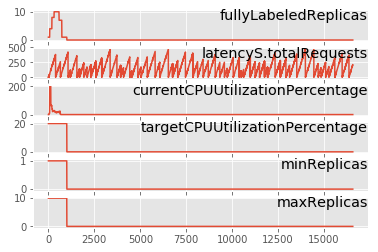

In [21]:
dfKeras.to_csv('smallTestSet.csv')

from matplotlib import pyplot
# load dataset
dataset = read_csv('smallTestSet.csv', header=0, index_col=0)
values = dataset.values
# specify columns to plot
groups = [0, 1, 2, 3,4,5]
i = 1
# plot each column
pyplot.figure()
for group in groups:
	pyplot.subplot(len(groups), 1, i)
	pyplot.plot(values[:, group])
	pyplot.title(dataset.columns[group], y=0.5, loc='right')
	i += 1
pyplot.show()

In [22]:
from sklearn import preprocessing
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 
# load dataset
dataset = read_csv('smallTestSet.csv', header=0, index_col=0)
values = dataset.values
# integer encode direction
encoder = preprocessing.LabelEncoder()
values[:,5] = encoder.fit_transform(values[:,5])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
reframed.drop(reframed.columns[[ 7,8,9,10,11]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  var1(t)
1        0.1   0.002132        0.0        1.0        1.0        1.0      0.1
2        0.1   0.004264        0.0        1.0        1.0        1.0      0.1
3        0.1   0.000000        0.0        1.0        1.0        1.0      0.1
4        0.1   0.006397        0.0        1.0        1.0        1.0      0.1
5        0.1   0.010661        0.0        1.0        1.0        1.0      0.1


In [29]:
valuesLarge = reframed.values
n_train_samp = 300
train = valuesLarge[:n_train_samp, :]
test = valuesLarge[n_train_samp:, :]
num_features=6
dim = num_features - 1

In [30]:
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

In [31]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(300, 1, 6) (300,) (16269, 1, 6) (16269,)


Using Theano backend.
WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
C:\Users\ansjin\Anaconda\lib\site-packages\theano\theano\configdefaults.py:560: UserWarning:


WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
C:\Users\ansjin\Anaconda\lib\site-packages\keras\keras\layers\recurrent.py:2024: UserWarning:

RNN dropout is no longer supported with the Theano backend due to technical limitations. You can either set `dropout` and `recurrent_dropout` to 0, or use the TensorFlow backend.



Train on 300 samples, validate on 16269 samples
Epoch 1/50
 - 6s - loss: 0.5595 - val_loss: 0.0450
Epoch 2/50
 - 5s - loss: 0.5489 - val_loss: 0.0511
Epoch 3/50
 - 5s - loss: 0.5383 - val_loss: 0.0571
Epoch 4/50
 - 5s - loss: 0.5277 - val_loss: 0.0633
Epoch 5/50
 - 6s - loss: 0.5170 - val_loss: 0.0694
Epoch 6/50
 - 6s - loss: 0.5063 - val_loss: 0.0755
Epoch 7/50
 - 6s - loss: 0.4954 - val_loss: 0.0817
Epoch 8/50
 - 6s - loss: 0.4843 - val_loss: 0.0879
Epoch 9/50
 - 6s - loss: 0.4731 - val_loss: 0.0942
Epoch 10/50
 - 5s - loss: 0.4616 - val_loss: 0.1005
Epoch 11/50
 - 5s - loss: 0.4498 - val_loss: 0.1069
Epoch 12/50
 - 5s - loss: 0.4376 - val_loss: 0.1132
Epoch 13/50
 - 5s - loss: 0.4252 - val_loss: 0.1197
Epoch 14/50
 - 6s - loss: 0.4124 - val_loss: 0.1263
Epoch 15/50
 - 6s - loss: 0.3993 - val_loss: 0.1333
Epoch 16/50
 - 5s - loss: 0.3878 - val_loss: 0.1389
Epoch 17/50
 - 6s - loss: 0.3816 - val_loss: 0.1438
Epoch 18/50
 - 6s - loss: 0.3759 - val_loss: 0.1484
Epoch 19/50
 - 6s - loss:

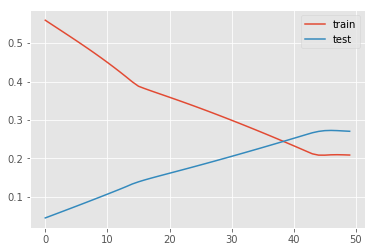

In [32]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
model = Sequential()
model.add(LSTM(2, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=50, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scalerSmall.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scalerSmall.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

In [ ]:
pyplot.plot(inv_y, label = 'Actual')
pyplot.plot(inv_yhat, label = 'Predicted')
pyplot.legend()
pyplot.show()